In [1]:
import tone
import utils
from utils import *

tone.utils.ipython.autoreload(utils)
tone.utils.learning.ignore_warning()
device = tone.utils.learning.try_use_device()
device

device(type='cuda')

In [2]:
lags = 12
batch_size = 256
epoch = 20

model = utils.CNN()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

losses = utils.fit(
    model=model,
    dataset=utils.SineDataset(lags),
    criterion=criterion,
    optimizer=optimizer,
    epoch=epoch,
    batch_size=batch_size,
    device=device,
    shuffle=True,
    progress=True,
    step_callback=None,
)

(20/20) | (39/39): 100%|██████████| 780/780 [00:05<00:00, 139.99it/s, loss=0.00125406]


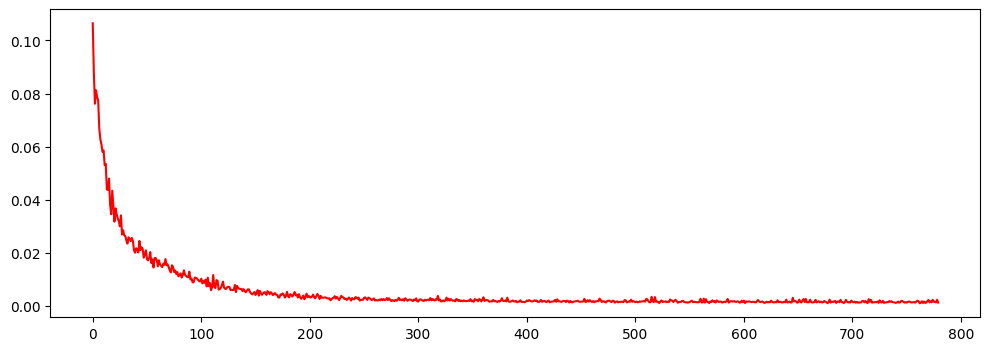

In [3]:
fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(losses, 'r')
plt.show()
plt.close()

In [4]:
tone.utils.learning.save_pickle(model, "models/cnn.pt")

In [5]:
pts = glob.glob("models/*.pt")
models = []
for pt in pts:
    model = tone.utils.learning.load_pickle(pt)
    models.append(model)

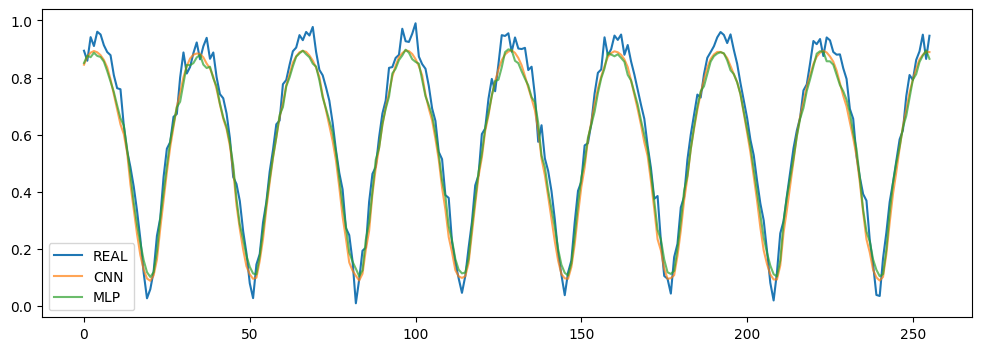

In [6]:
dataset = utils.SineDataset(lags, train=False, len=400)

real, preds = utils.test(models, dataset, batch_size, device, progress=False)


fig = plt.figure(figsize=(12, 4))
ax = fig.subplots()
ax.plot(real.detach().cpu(), label='REAL')
for i, pred in enumerate(preds):
    ax.plot(pred.detach().cpu(), alpha=0.7, label=f'{type(models[i]).__name__}')

plt.legend()
plt.show()
plt.close()


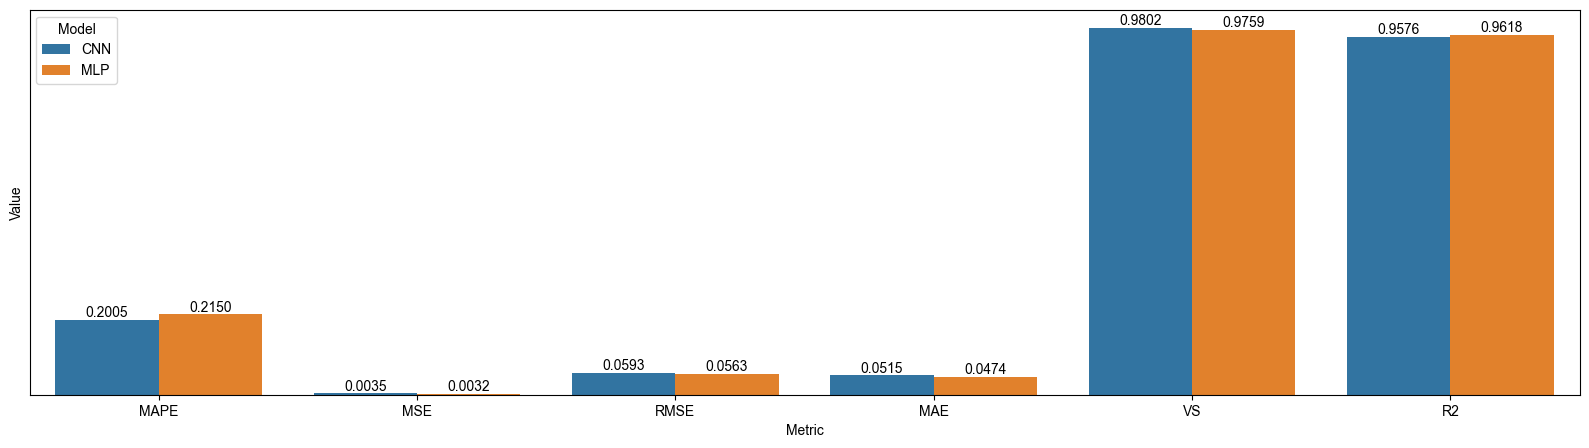

,Metric,CNN,MLP
0,MAPE,0.200469,0.215027
1,MSE,0.003520,0.003167
2,RMSE,0.059327,0.056274
3,MAE,0.051498,0.047376
4,VS,0.980204,0.975870
5,R2,0.957582,0.961836


In [7]:
df = pd.DataFrame()
data = []

for i, model in enumerate(models):
    name = type(model).__name__

    m = tone.utils.learning.metrics(
        real.detach().cpu().numpy(),
        preds[i].detach().cpu().numpy()
    )

    df['Metric'] = [key.upper() for key in m.keys()]
    df[name] = m.values()

    for key, value in m.items():
        data.append([name, key.upper(), value])

data = pd.DataFrame(data, columns=['Model', 'Metric', 'Value'])

fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.barplot(data, x='Metric', y='Value', hue='Model', ax=ax)
for container in ax.containers:
    ax.bar_label(container, fmt='%.4f')
ax.set_yticks([])
sns.set_style('darkgrid')
plt.show()

df